In [83]:
import torch
from pytorch_lightning import LightningModule
from deepautoqc.models import TransfusionCBRCNN

class CheckpointedModel(TransfusionCBRCNN, LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

checkpoint_path = '/Users/Dominik/Charite/DeepAutoQC/src/deepautoqc/ckpts/tiny-11-2532.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Assuming the labels were ['usable', 'unusable']
model = CheckpointedModel(model_name='tiny', labels=['usable', 'unusable'])
# Remove 'model.' prefix in the checkpoint keys
state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}

# Load the modified state_dict into the model
model.load_state_dict(state_dict)

#model.load_state_dict(checkpoint['state_dict'])
model.eval()  # set the model in evaluation mode


CheckpointedModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (global_pool): Sequential(
  

In [84]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [85]:
backward_hook = model.features[14].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.features[14].register_forward_hook(forward_hook, prepend=False)

1.0
(690, 691, 3)


torch.Size([1, 3, 690, 691])

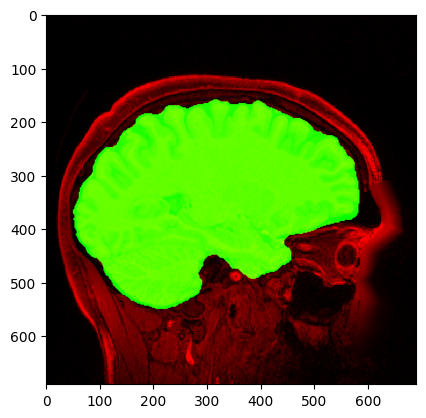

In [103]:
import numpy as np
from torchvision.transforms import functional as F
from deepautoqc.utils import load_from_pickle
from deepautoqc.data_structures import BrainScan
import matplotlib.pyplot as plt

# Assuming test_img is a numpy array of shape (690, 551, 3)
# Reshape to (3, 690, 551) and normalize to [0, 1] range
#test_img = test_img.transpose((2, 0, 1)) / 255.0

pkl_path = '/Volumes/PortableSSD/data/skullstrip_rpt_processed_usable/_sub-102008_report-skull.pkl'

subjects_data = load_from_pickle(pkl_path)
test_img = subjects_data[12].img
print(test_img.max().item())
print(test_img.shape)
plt.imshow(test_img)

test_img = test_img.transpose((2, 0, 1))# ADD the "/255" Division for normalization as the network expects that

# Add an extra dimension to simulate the batch size of 1
test_img = np.expand_dims(test_img, axis=0)

# Convert to tensor
test_img_tensor = torch.tensor(test_img, dtype=torch.float32)
test_img_tensor.shape

In [104]:
label_to_int = {"usable": 0, "unusable": 1}
output = model(test_img_tensor)
# Reverse mapping
int_to_label = {v: k for k, v in label_to_int.items()}
print(int_to_label)
_, predicted_idx = torch.max(output, 1)
print(output[-1])
predicted_class = int_to_label[predicted_idx.item()]
print(predicted_class)

Forward hook running...
Activations size: torch.Size([1, 512, 77, 78])
{0: 'usable', 1: 'unusable'}
tensor([-2.6565,  1.5968], grad_fn=<SelectBackward0>)
unusable


In [110]:
import torch.nn.functional as F
# since we're feeding only one image, it is a 3d tensor (3, 256, 256). 
# we need to unsqueeze to it has 4 dimensions (1, 3, 256, 256) as 
# the model expects it to.
output = model(test_img_tensor)
output.shape
output_softmax = F.softmax(output, dim=1)
print(output_softmax)
target = torch.tensor([0])  # target class either usable=0 or unusable=1
loss = F.cross_entropy(output, target) 
#loss = output.sum()  # previous method of summing losses across classes
loss.backward()

Forward hook running...
Activations size: torch.Size([1, 512, 77, 78])
tensor([[0.0140, 0.9860]], grad_fn=<SoftmaxBackward0>)
Backward hook running...
Gradients size: torch.Size([1, 512, 77, 78])


In [111]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

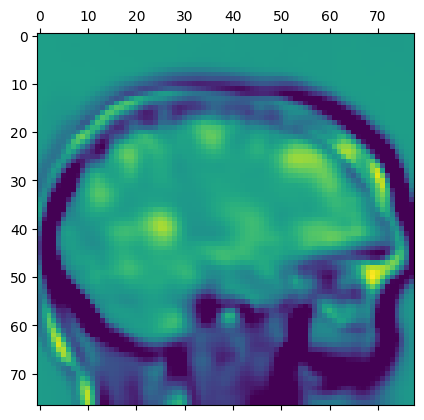

In [112]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())

Original width: 690, Original height: 691
torch.Size([3, 690, 691])


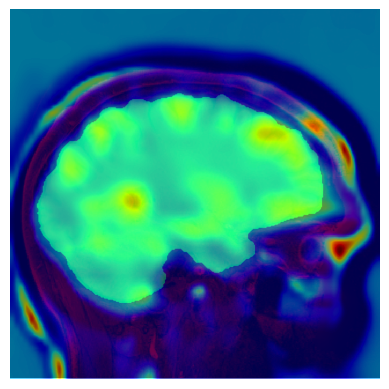

In [113]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

original_width, original_height = test_img_tensor.squeeze(0).shape[1:]
print(f"Original width: {original_width}, Original height: {original_height}")

# First plot the original image
plot_img = test_img_tensor.squeeze(0)


print(plot_img.shape)
ax.imshow(to_pil_image(plot_img, mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
#overlay = to_pil_image(heatmap.detach(), mode='F').resize((551,690), resample=PIL.Image.BICUBIC)
overlay = to_pil_image(heatmap.detach(), mode='F').resize((original_width, original_height), resample=PIL.Image.BICUBIC)


# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.6, interpolation='nearest') # deleted extent parameter

# Show the plot
plt.show()

tensor(0.) tensor(1.)


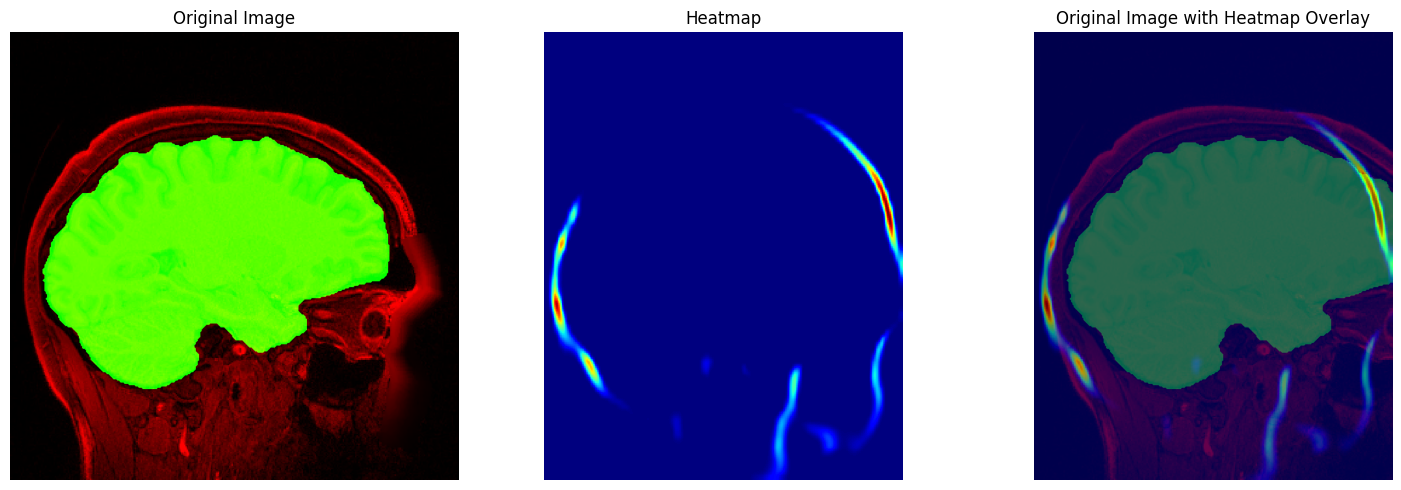

In [109]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

# Create a figure and plot the first image
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5)) # Create 3 subplots side by side

# First plot the original image
plot_img = test_img_tensor.squeeze(0)
print(plot_img.min(), plot_img.max())

axs[0].imshow(to_pil_image(plot_img, mode='RGB'))
axs[0].axis('off')
axs[0].set_title('Original Image')

# Plot just the heatmap
overlay = to_pil_image(heatmap.detach(), mode='F').resize((552,690), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
axs[1].imshow(overlay, interpolation='nearest')
axs[1].axis('off')
axs[1].set_title('Heatmap')

# Plot the original image with the heatmap overlay
axs[2].imshow(to_pil_image(plot_img, mode='RGB'))
axs[2].imshow(overlay, alpha=0.6, interpolation='nearest')
axs[2].axis('off')
axs[2].set_title('Original Image with Heatmap Overlay')

# Show the plot
plt.tight_layout()  # adjust the layout to avoid overlap
plt.show()


In [ ]:
backward_hook.remove()
forward_hook.remove()